In [1]:
# # https://github.com/maxw1489/Mask_RCNN (tensorflow 2.9.1)

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print("Num GPUs Available: ",
len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

2.15.0
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4625473458240118117
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10180624384
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2180333366412471862
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:
import logging
import os
import json
import cv2
import sys
import math
import random
import warnings

import cv2

import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

dir_root = os.path.abspath("./")

# sys.path.append(os.path.join(dir_root, "maskrcnn/Mask_RCNN-master/"))  # To find local version
# sys.path.append(os.path.join(dir_root, "maskrcnn/Mask_RCNN-master_tf2p9/"))  # To find local version
# sys.path.append(os.path.join(dir_root, "maskrcnn/mask-rcnn-tf2-us-main/"))  # To find local version

# sys.path.append(os.path.join(dir_root, "maskrcnn/mask-rcnn-tf2-us-main/samples/coco/"))  # To find local version


from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

import imgaug as ia
import imgaug.augmenters as iaa



logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    # 0 = all messages are logged (default behavior)
    # 1 = INFO messages are not printed
    # 2 = INFO and WARNING messages are not printed
    # 3 = INFO, WARNING, and ERROR messages are not printed


warnings.filterwarnings('ignore')

In [4]:
# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices("GPU") 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
NUM_OF_IMAGES = 1000#0
NUM_OF_VAL_IMAGES = int(NUM_OF_IMAGES*0.2)

In [6]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "55_shapes_resnet"

    BACKBONE = "resnet101" # "shvit"

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a SHViT  backbone.
    # BACKBONE_STRIDES = [8, 16, 32, 64, 128] # 128 added as they add 64 in the paper (original strides were [4,8,16,32] -> [4,8,16,32,64], maybe because P5 was upsampled by factor 2??)
    BACKBONE_STRIDES= [4, 8, 16, 32, 64] # resnet


    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512 # 128
    IMAGE_MAX_DIM = 512 # 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels resnet
    # RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128 # 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = int(NUM_OF_IMAGES / IMAGES_PER_GPU)

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = int(NUM_OF_VAL_IMAGES / IMAGES_PER_GPU)

    RUN_EAGERLY = False    



config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            #print("bg_color", bg_color)
            #print("shapes", shapes)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i + 1] = self.draw_shape(mask[:, :, i:i + 1].copy(),
                                                  shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(
                occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            image = cv2.rectangle(image, (x - s, y - s),
                                  (x + s, y + s), color, -1)
        elif shape == "circle":
            image = cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y - s),
                                (x - s / math.sin(math.radians(60)), y + s),
                                (x + s / math.sin(math.radians(60)), y + s),
                                ]], dtype=np.int32)
            image = cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height // 4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y - s, x - s, y + s, x + s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(
            np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [8]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(NUM_OF_IMAGES, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(NUM_OF_VAL_IMAGES, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [9]:
mask, idx = dataset_val.load_mask(2)
np.max(mask)

1

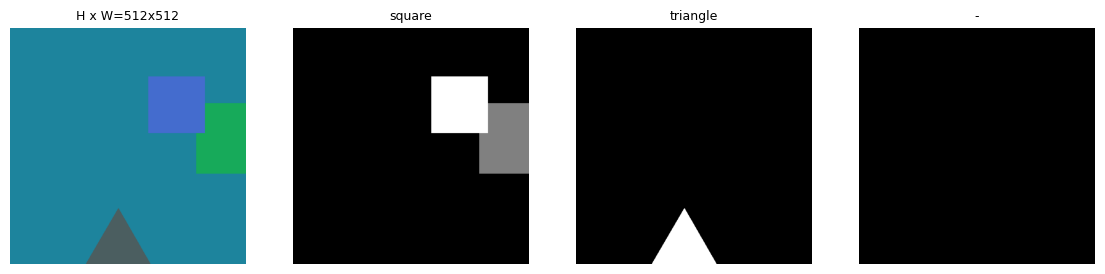

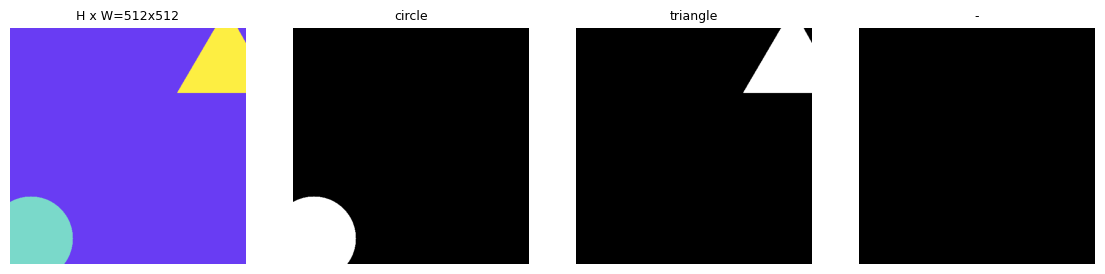

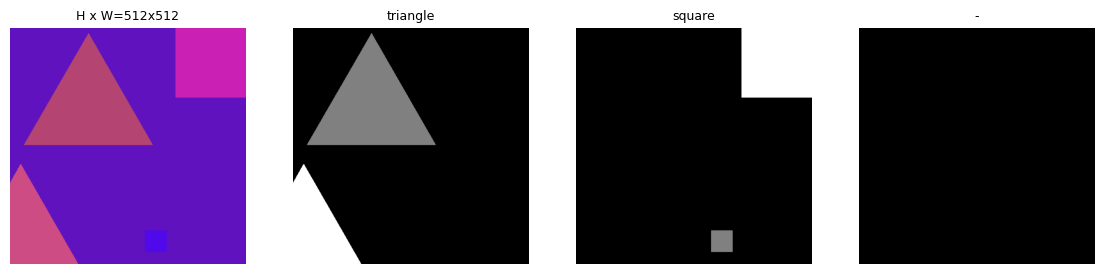

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 3)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    cv2.imwrite(f"./shape_test_images/shape_test_image_{image_id}.png", image)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names, limit=3)

## Create Model and Load Trained Weights

In [11]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augmentation = iaa.Sequential([
                                iaa.Fliplr(0.5), 
                                iaa.Flipud(0.5),
                                #sometimes(iaa.Crop(percent=(0, 0.1))),
                                sometimes(iaa.Affine(
                                            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                            rotate=(-45, 45),
                                            #shear=(-16, 16),
                                            #order=[0, 1],
                                            #cval=(0, 255),
                                            #mode=ia.ALL
                                            )
                                        ),
                            ])

In [12]:
dir_model = os.path.join(dir_root, "logs/")

#COCO_MODEL_PATH = os.path.join(dir_root, "shoes/mask_rcnn_coco.h5")    
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="training", config=config, model_dir=dir_model)

# Load weights trained on MS-COCO
#model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [13]:
EPOCHS = [1,500]

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, min_lr=1e-8)
csv_logger_head = tf.keras.callbacks.CSVLogger(filename=config.NAME + "_training.log", append=False)
csv_logger_all = tf.keras.callbacks.CSVLogger(filename=config.NAME + "_training.log", append=True)

In [14]:
filename=config.NAME + "_training.log"
filename

'55_shapes_resnet_training.log'

In [15]:
model.compile(layers="head")
model.summary()

Selecting layers to train
Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_image[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, None, None, 64)       9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNorm)        (None, None, None, 64)       256   

In [16]:
model.train(dataset_train, dataset_val, 
            epochs=EPOCHS[0], 
            augmentations=None, #augmentation, 
            custom_callbacks=[stop_early, reduce_lr, csv_logger_head])
history = model.keras_model.history.history


Starting at epoch 0.

Checkpoint Path: /mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/VisionTransformers/shoes/logs/55_shapes_resnet20241208T1756/mask_rcnn_55_shapes_resnet_{epoch:04d}.h5
n workers used: 32


W0000 00:00:1733677026.513051   52374 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -638 } dim { size: -121 } dim { size: -122 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -24 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -24 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 10180624384 

250/250 [==============================] - ETA: 0s - loss: 39.4611 - rpn_class_loss: 13.1891 - rpn_bbox_loss: 6.6839 - mrcnn_class_loss: 11.2467 - mrcnn_bbox_loss: 7.5036 - mrcnn_mask_loss: 1.2889

W0000 00:00:1733677055.669019   52374 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -638 } dim { size: -121 } dim { size: -122 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -24 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -24 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 10180624384 

250/250 [==============================] - 40s 121ms/step - loss: 39.4611 - rpn_class_loss: 13.1891 - rpn_bbox_loss: 6.6839 - mrcnn_class_loss: 11.2458 - mrcnn_bbox_loss: 7.5028 - mrcnn_mask_loss: 1.2888 - val_loss: 39.8793 - val_rpn_class_loss: 13.3999 - val_rpn_bbox_loss: 6.9760 - val_mrcnn_class_loss: 11.0297 - val_mrcnn_bbox_loss: 7.1984 - val_mrcnn_mask_loss: 1.2752 - lr: 0.0010


In [17]:
model.compile(layers="all")
model.summary()

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a

In [ ]:
model.train(dataset_train, dataset_val, 
            epochs=EPOCHS[1], 
            augmentations=None, #augmentation, 
            custom_callbacks=[stop_early, reduce_lr, csv_logger_all])
new_history = model.keras_model.history.history
for k in new_history: 
    history[k] = history[k] + new_history[k]


Starting at epoch 1.

Checkpoint Path: /mnt/c/Users/ChangGeng/Desktop/FAU/Semester 07/Bachelorarbeit/VisionTransformers/shoes/logs/55_shapes_resnet20241208T1756/mask_rcnn_55_shapes_resnet_{epoch:04d}.h5
n workers used: 32
Epoch 2/500


W0000 00:00:1733677085.042785   52374 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1086 } dim { size: -613 } dim { size: -614 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -38 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -38 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 10180624384

250/250 [==============================] - ETA: 0s - loss: 2.9384 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.1780 - mrcnn_class_loss: 0.4374 - mrcnn_bbox_loss: 1.3556 - mrcnn_mask_loss: 0.6643

W0000 00:00:1733677157.471928   52374 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -638 } dim { size: -121 } dim { size: -122 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -24 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -24 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 4090" frequency: 2520 num_cores: 128 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8800" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 75497472 shared_memory_size_per_multiprocessor: 102400 memory_size: 10180624384 

250/250 [==============================] - 101s 251ms/step - loss: 2.9384 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.1780 - mrcnn_class_loss: 0.4367 - mrcnn_bbox_loss: 1.3534 - mrcnn_mask_loss: 0.6641 - val_loss: 2.3205 - val_rpn_class_loss: 0.0212 - val_rpn_bbox_loss: 0.9308 - val_mrcnn_class_loss: 0.1985 - val_mrcnn_bbox_loss: 0.5956 - val_mrcnn_mask_loss: 0.5744 - lr: 0.0010
Epoch 3/500
250/250 [==============================] - 60s 240ms/step - loss: 2.4144 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0107 - mrcnn_class_loss: 0.2267 - mrcnn_bbox_loss: 0.6155 - mrcnn_mask_loss: 0.5602 - val_loss: 2.2703 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 0.8942 - val_mrcnn_class_loss: 0.2292 - val_mrcnn_bbox_loss: 0.5831 - val_mrcnn_mask_loss: 0.5440 - lr: 0.0010
Epoch 4/500
250/250 [==============================] - 59s 236ms/step - loss: 2.0021 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.8511 - mrcnn_class_loss: 0.1906 - mrcnn_bbox_loss: 0.5012 - mrcnn_mask_loss: 0.5222 - val_loss: 

In [ ]:
epochs = range(len(list(history["loss"])))
epochs = tuple(e + 1 for e in epochs)


plt.figure(figsize=(18, 6))

plt.subplot(131, title="losses")
plt.plot(epochs, history["loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="valid loss")
plt.xticks(range(0, epochs[-1]+1, 20))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="train class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="valid class loss")
plt.xticks(range(0, epochs[-1]+1, 20))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()

plt.subplot(133)
plt.plot(epochs, history["mrcnn_mask_loss"], label="train mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="valid mask loss")
plt.xticks(range(0, epochs[-1]+1, 20))
plt.yscale("log")
for xpos in (epochs[0], epochs[-1]):
    plt.axvline(x=xpos, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.show()

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=dir_model)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
model.summary()

In [ ]:
# image = cv2.imread("./shape_test_images/shape_test_image_653.png") # check if image in folder exists - otherwise change name, if necessary
image = cv2.imread("./shape_test_images/shape_test_image_102.png") # check if image in folder exists - otherwise change name, if necessary

# Run detection
results = model.detect([image], verbose=1)
res = results[0]
print(res["rois"])
print(res["class_ids"])
print(res["scores"])
print(dataset_train.class_names)

# Visualize results
visualize.display_instances(image, res["rois"], res["masks"], res["class_ids"], dataset_train.class_names, res["scores"], figsize=(8, 8))

In [ ]:
# Test on a random image, 
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id) # ground truth
log("gt_bbox", gt_bbox) # ground truth
log("gt_mask", gt_mask) # ground truth

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_val.class_names, figsize=(8, 8))